### Intro

There are a lot of unknowns when modeling complex data: which variable selection method to use (if any), which ML algorithms will perform best (and is it simply a matter of hyperparameter specification?), etc.

Here I want to write a set of loops to look at all these issues. I'll include a range of variable selection methods (variables selected by VIF, LASSO, low correlations among each other, my own hunches based on biology, and environmental conditions divided by time point of each variable (same day, day before, etc.)). I'll also investigate how different classification algorithms (random forests, logistic, SVC) perform on a range of evaluation criteria (ROC, sensitivity, specificity, etc.). Regression approaches and evaluation was performed in a separate file.
 

Start by importing the libraries and functions I'll need:

In [245]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import warnings


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, StackingRegressor

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.svm import SVR, SVC
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeRegressor

from pandas_profiling import ProfileReport
from sklearn.metrics import roc_curve, auc, roc_auc_score

from statistics import mean

from pprint import pprint

## Functions:

Next, define some functions that will help evaluate the models.

In [246]:
def score_metrics(y_true, y_proba, prob_threshold):
    """"
    Produces a table of the most relevant model evaluation metrics for classification problems
    
    Requires a vector of the true target values and a vector of predicted probabilities (from the model) for
       those values
    """
    y_pred = y_proba >= prob_threshold
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2*(precision*recall)/(precision+recall)
    AUC = roc_auc_score(y_true, y_proba)
    
    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC']
    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC], 
                      index=row_names, columns=["value"])
    return df

In [247]:
def score_metrics_no_prob(y_true, y_pred):
    """"
    Produces a table of the most relevant model evaluation metrics for classification problems
    
    Requires a vector of the true target values and a vector of predicted classes (not probabilities)
       for those values
    """
    #y_pred = y_proba >= 0.5
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2*(precision*recall)/(precision+recall)
    AUC = roc_auc_score(y_true, y_pred)
    
    row_names = ['accuracy', 'precision', 'recall', 'specificity', 'F1', 'AUC'
                ]
    df = pd.DataFrame(data=[accuracy, precision, recall, specificity, f1, AUC
                           ], 
                      index=row_names, columns=["value"])
    return df

Now we can begin loading in the data and investigating it:

In [248]:
# load in my data:
ascospores = pd.read_csv("2018-21 burkard and weather data for modelling.csv", index_col = False)

In [249]:
# convert the 'RainYN' column to a character, since I think this may cause issues with
# the analysis downstream:
ascospores['RainYN'] = ascospores.RainYN.astype(str)

In [250]:
# I think different types of NA values are getting in the way of downstream analysis, so here I'll try to 
#  change them all into the exact same format:
ascospores.replace(dict.fromkeys(['N/A', 'nan', '', 'NA'], None))

,Date,Year,Province,SamplerNo.x,FieldID,SamplerType,ExtractionGroup,qPCRPlate,JDay,SampleID,...,MeanSoilTemp,DiffMeanSoilT,MeanSoilT_1d,MaxSoilTemp,DiffMaxSoilT,MaxSoilT_1d,MinSoilTemp,DiffMinSoilT,MinSoilT_1d,jday
0,2018-06-13,2018,Alberta,Taber,1804,Burkard,NaN,NaN,164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-14,2018,Alberta,Taber,1804,Burkard,NaN,NaN,165.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0
2,2018-06-15,2018,Alberta,Taber,1804,Burkard,NaN,NaN,166.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.0
3,2018-06-16,2018,Alberta,Taber,1804,Burkard,NaN,NaN,167.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.0
4,2018-06-17,2018,Alberta,Taber,1804,Burkard,NaN,NaN,168.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,2021-08-12,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.0
2693,2021-08-15,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.0
2694,2021-08-17,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0
2695,2021-08-18,2021,Manitoba,NaN,Morden21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0


In [251]:
ascospores.columns

Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',
       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',
       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',
       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',
       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',
       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',
       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',
       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',
       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',
       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',
       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',
       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',
       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
       'MaxWC', 'DiffMaxWC

In [252]:
# remove any lines for which the response variable is missing:
ascospores = ascospores.dropna(subset=['SsMean'])

In [253]:
# make sure that RainYN is a categorical variable:
ascospores['RainYN'] = ascospores['RainYN'].astype('category')

In [254]:
# select only AB fields and remove the one sampler that was collecting from outside the field;
#  also remove the fields that didn't collect weather data (can see R 'Correlations of Ascospores and Weather...R'
#  file to assess this):

to_keep = ["1804", "1810", "1814", "1904", "1906", "1910", "1915", "1917", "1919", 
           "2001", "2003", "2004", "2006", "2007", "2042", "2104", "2105-in", "2125",
           "2128", "2144", "2146"]

asco_ab = ascospores.loc[ascospores['FieldID'].isin(to_keep)]

asco_ab.shape

(1046, 97)

In [255]:
asco_ab['FieldID'].unique()

array(['1804', '1810', '1814', '1904', '1906', '1910', '1915', '1917',
       '1919', '2001', '2004', '2006', '2007', '2042', '2104', '2105-in',
       '2125', '2128', '2144', '2146'], dtype=object)

In [256]:
asco_ab.columns

Index(['Date', 'Year', 'Province', 'SamplerNo.x', 'FieldID', 'SamplerType',
       'ExtractionGroup', 'qPCRPlate', 'JDay', 'SampleID', 'SsCtMean',
       'SsCtSD', 'SsMean', 'logSsMean', 'VolumeSampled', 'TtCt', 'TtSD',
       'Water', 'week', 'month', 'SsMean_t1', 'logSs_t1', 'SamplerNo.y',
       'MeanWetness', 'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet',
       'MaxWet_1d', 'MinWetness', 'DiffMinWet', 'MinWet_1d', 'MeanTemp',
       'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp',
       'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH',
       'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d',
       'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD',
       'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d',
       'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip', 'Precip_1d',
       'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
       'MaxWC', 'DiffMaxWC

In [258]:
# drop columns that are redundant, not relevant, or contain no useful information;
asco_minimal = asco_ab.drop(['Date', 'Year', 'Province', 'SamplerNo.x', 
                             #'FieldID', 
                             'SamplerType', 
                             'ExtractionGroup','qPCRPlate', 'JDay', 'SampleID', 'SsCtMean', 
                             'SsCtSD', 'VolumeSampled', 'TtCt', 'TtSD', 'Water', 
                             #'week', 'month', 
                             'SamplerNo.y', 'MeanWetness',
                             'DiffMeanWet', 'MeanWet_1d', 'MaxWetness', 'DiffMaxWet', 'MaxWet_1d',
                             'MinWetness', 'DiffMinWet', 'MinWet_1d', #'RainYN', 
                             'MaxRain', 'MinRain', 
                             #'MeanWC', 'DiffMeanWC', 'MeanWC_1d',
                             #'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d',
                             #'MeanSoilTemp', 'DiffMeanSoilT',
                             #'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',
                             #'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d', 
                             'jday'], axis = 1)

In [259]:
print(asco_minimal.shape)
asco_minimal.columns

(1046, 69)


Index(['FieldID', 'SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1',
       'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',
       'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',
       'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',
       'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',
       'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',
       'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d',
       'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanWC', 'DiffMeanWC',
       'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',
       'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',
       'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',
       'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'],
      dtype='object')

### What to do with the soil data?

Some of the fields that were surveyed have soil temperature and soil moisture data, but many don't. The problem with INCLUDING these variables is that either (i) many samples would be excluded due to missing values here or (ii) imputation would make up values for all samples from a field (not reliable). The problem with EXCLUDING these variables is that they are potentially very important predictors in the model.

I've performed analyses both ways, but here I include only the analysis for the data set WITHOUT soil temperature and moisture variables.

In [260]:
# in Alberta, filtering by complete Soil Temp variables will ensure that this there are also
#   complete Soil WC variables:
asco_soil = asco_minimal.dropna(subset=['MeanSoilTemp'])
asco_nosoil = asco_minimal.drop(['MeanWC', 'DiffMeanWC', 'MeanWC_1d', 'MaxWC',
       'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC', 'MinWC_1d', 'MeanSoilTemp', 
       'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT', 'MaxSoilT_1d',
       'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d'], axis = 1)
print(asco_soil.shape)
print(asco_nosoil.shape)

(620, 69)
(1046, 51)


From here on, I'll just use the 'asco_nosoil' data set.

### Creating the train and test data sets: 

Rather than doing a random split, I'm going to select one field from each year for the test set, and use the remainder for the training set - this seems more realistic in terms of what we want to predict. For instance, in any given year, we want to know whether our model can predict spore occurrence in a range of new fields.

In [261]:
asco_trainvalid_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin(["1804",  "1814", "1904", "1906", "1915", "1917", "1919", 
           "2001", "2003",  "2006", "2007", "2042", "2104", "2105-in", "2125",
            "2144", "2146"])]
asco_test_nosoil = asco_nosoil.loc[asco_nosoil['FieldID'].isin(["1810", "1910", "2004", "2128"])]


In [262]:
print(asco_trainvalid_nosoil.shape)
print(asco_test_nosoil.shape)

(855, 51)
(191, 51)


In [263]:
# drop the 'FieldID' column for these data sets:
asco_trainvalid_nosoil = asco_trainvalid_nosoil.drop(['FieldID'], axis = 1)
asco_test_nosoil = asco_test_nosoil.drop(['FieldID'], axis = 1)

In [264]:
asco_trainvalid_nosoil.columns

Index(['SsMean', 'logSsMean', 'week', 'month', 'SsMean_t1', 'logSs_t1',
       'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT', 'MaxT_1d',
       'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH', 'MeanRH_1d',
       'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH', 'MinRH_1d',
       'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h', 'MaxDiffRH_3h',
       'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD', 'DiffMaxVPD',
       'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'MinVPD_1d', 'TotalPrecip',
       'Precip_1d', 'RainYN', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP',
       'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d'],
      dtype='object')

Ok, so there's still one remaining question about the data set before moving forward. What response variable do we want to model? We could use:
   - SsMean (raw counts of spores)
   - logSs (the logarithm + 1 counts of spores)

Because in this analysis we're doing classification, we'll stick with the raw counts, 'SsMean', to establish our threshold cutoffs (discussed more below). However, for regression methods we should probably use the 'logSs' since a few large outliers could greatly affect the analysis.

Split the data appropriately:

In [265]:
# response variable:
y_trainvalid = asco_trainvalid_nosoil['SsMean']
y_test = asco_test_nosoil['SsMean']

y_trainvalid_log = asco_trainvalid_nosoil['logSsMean']
y_test_log = asco_test_nosoil['logSsMean']

In [266]:
# the X data sets without soil variables:
X_trainvalid = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)
X_test = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'logSs_t1'], axis = 1)

X_trainvalid_log = asco_trainvalid_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)
X_test_log = asco_test_nosoil.drop(['SsMean', 'logSsMean', 'SsMean_t1'], axis = 1)

In [267]:
print(X_trainvalid.shape)
print(X_trainvalid_log.shape)
print(X_test.shape)
print(X_test_log.shape)

(855, 47)
(855, 47)
(191, 47)
(191, 47)


Make two data sets: first, make one of the log(no. ascospores) for regression modeling; second, make one of (no. ascospores > x) for classification modeling

In [268]:
# data sets for regression modeling:
### make data frames for X data sets; export these for use in other programs (R)

#X_trainvalid_soil_log_df = pd.DataFrame(X_trainvalid_soil_log)
#X_test_soil_log_df = pd.DataFrame(X_test_soil_log)
#X_trainvalid_nosoil_log_df = pd.DataFrame(X_trainvalid_nosoil_log)
#X_test_nosoil_log_df = pd.DataFrame(X_test_nosoil_log)

#X_train_df.columns = new_columns
#X_valid_df.columns = new_columns
#X_test_df.columns = new_columns

#X_trainvalid_soil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_soil.csv")
#X_test_soil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_soil.csv")
#X_trainvalid_nosoil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_trainvalid_nosoil.csv")
#X_test_nosoil_log_df.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/X_test_nosoil.csv")

#y_trainvalid_soil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_soil.csv")
#y_test_soil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_soil.csv")
#y_trainvalid_nosoil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_trainvalid_nosoil.csv")
#y_test_nosoil_log.to_csv("~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/y_test_nosoil.csv")



### Thresholds for classification modeling:

Aaaaaaaaalright. One of the tricky things about this fungus is that the scientific community doesn't know much about how many spores in the air will lead to disease in the field. As a result, I've decided to try a range of (admittedly arbitrary) cutofs to see whether any of these will be modeled better. This may not translate to biological importance, but at least we'd know we could predict a certain level of spores with some accuracy. I've chosen thresholds of 100, 200, 500, and 1000 spores per day.

In [269]:
# data sets WITHOUT soil data:
### data sets for classification modeling:
y100_trainvalid = np.where(y_trainvalid >= 100, 1, 0)
y100_test = np.where(y_test >= 100, 1, 0)

y200_trainvalid = np.where(y_trainvalid >= 200, 1, 0)
y200_test = np.where(y_test >= 200, 1, 0)

y500_trainvalid = np.where(y_trainvalid >= 500, 1, 0)
y500_test = np.where(y_test >= 500, 1, 0)

y1000_trainvalid = np.where(y_trainvalid >= 1000, 1, 0)
y1000_test = np.where(y_test >= 1000, 1, 0)

And this is probably not ideal practice, but I do want to get a sense of how many 'cases' we have in each of these data sets:

In [270]:
all_y = [y100_trainvalid, y100_test,
         y200_trainvalid, y200_test,
         y500_trainvalid, y500_test,
         y1000_trainvalid, y1000_test]

y_means = []
for y in all_y: 
    y_means.append(y.mean())

y_names = ['y100_trainvalid_nosoil', 'y100_test_nosoil',
           'y200_trainvalid_nosoil', 'y200_test_nosoil', 
           'y500_trainvalid_nosoil', 'y500_test_nosoil',
           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']

y_df = pd.DataFrame(data=y_means, index=y_names, columns=["Proportion of Ones"])
y_df

,Proportion of Ones
y100_trainvalid_nosoil,0.753216
y100_test_nosoil,0.612565
y200_trainvalid_nosoil,0.618713
y200_test_nosoil,0.455497
y500_trainvalid_nosoil,0.403509
y500_test_nosoil,0.287958
y1000_trainvalid_nosoil,0.249123
y1000_test_nosoil,0.225131


In [271]:
### Saving the test sets for use in R, or other programs:
## y_names defined above
#y_names = [#'y100_trainvalid_soil', 'y100_test_soil',
#           #'y200_trainvalid_soil', 'y200_test_soil', 
#           #'y500_trainvalid_soil', 'y500_test_soil',
#           #'y1000_trainvalid_soil', 'y1000_test_soil',
#           'y100_trainvalid_nosoil', 'y100_test_nosoil',
#           'y200_trainvalid_nosoil', 'y200_test_nosoil', 
#           'y500_trainvalid_nosoil', 'y500_test_nosoil',
#           'y1000_trainvalid_nosoil', 'y1000_test_nosoil']

#y_data = [#y100_trainvalid_soil, y100_test_soil,
#         #y200_trainvalid_soil, y200_test_soil,
#         #y500_trainvalid_soil, y500_test_soil,
#         #y1000_trainvalid_soil, y1000_test_soil,
#         y100_trainvalid_nosoil, y100_test_nosoil,
#         y200_trainvalid_nosoil, y200_test_nosoil,
#         y500_trainvalid_nosoil, y500_test_nosoil,
#         y1000_trainvalid_nosoil, y1000_test_nosoil]
#file_path = "~/Desktop/Data/Field Data Analysis/Modeling Data Sets from Python/"

#for i in np.arange(0, len(y_data)):
#    to_save = pd.DataFrame(list(y_data[i]))
#    to_save.to_csv(file_path + y_names[i] + ".csv")

# Variable Selection Methods:

Which set of variables to use for modeling is not necessarily clear. Below, I've included a range of options, but in order to get variables selected by LASSO, we need to run that model first:

### LASSO regression for variable selection:

In [272]:
# see what columns we have to consider:
print(X_trainvalid_log.columns)

Index(['week', 'month', 'logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'RainYN', 'MeanDP',
       'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP',
       'DiffMinDP', 'MinDP_1d'],
      dtype='object')


For all models we'll be using pipelines. We'll need to separate numeric and categorical features.

In [273]:
numeric_features = ['logSs_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d',
       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',
       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',
       'MinDP_1d']

# this variable set could be used to explore the differences in outcomes for
#    removing spore data from the analysis:
#numeric_feat_noasco = ['MeanTemp', 'DiffMeanT', 'MeanT_1d',
#       'MaxTemp', 'DiffMaxT', 'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d',
#       'MeanRH', 'DiffMeanRH', 'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d',
#       'MinRH', 'DiffMinRH', 'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
#       'MaxDiffRH_2h', 'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d',
#       'MaxVPD', 'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD',
#       'MinVPD_1d', 'TotalPrecip', 'Precip_1d', 'MeanDP', 'DiffMeanDP',
#       'MeanDP_1d', 'MaxDP', 'DiffMaxDP', 'MaxDP_1d', 'MinDP', 'DiffMinDP',
#       'MinDP_1d']

categorical_features = [#'week', 'month', 
    'RainYN']

drop_features = ['logSs_t1']

... and then make transformers to handle missing data for (i) numeric data and (ii) categorical data:

In [274]:
# create numeric transformer
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer()),
    ('scaler', StandardScaler())
])

In [275]:
# create categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first'))
])

Then we can make a preprocessor to hold these transformers:

In [276]:
# create preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_feat_nosoil),
    ('categorical', categorical_transformer, categorical_features)
])

Fit the preprocessor and get feature names:

In [277]:
preprocessor.fit(X_trainvalid_log);

In [278]:
ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = numeric_feat_nosoil + ohe_feature_names
new_columns;

In [279]:
# make data frame of the transformed features:
X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid_log),  index=X_trainvalid_log.index, 
                            columns=new_columns)
X_test = pd.DataFrame(preprocessor.transform(X_test_log),  index=X_test_log.index,  columns=new_columns)

Run LASSO on the data set:

In [280]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: which uses the log(no. spores) to model, rather than different thresholds;
#       the problem with using different thresholds is that then you end up with 4 sets of selected variables
#       (but this code is still there, just commented out)

# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

y_data_sets = [y100_trainvalid, y200_trainvalid, y500_trainvalid, y1000_trainvalid]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
#y_data_sets = [y_trainvalid_nosoil_log]
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once - this is more useful if we're wanting to use multiple data sets
#    (i.e. if we were to use each of the different threshold data sets):
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    # save coefficients in a data frame:
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
# return the data frame:
larcv_coefs.columns = ['y100', 'y200', 'y500', 'y1000']
#larcv_coefs.columns = ['logSs']

In [281]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
lasso_nosoil_log = larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='y100', ascending=False)
lasso_nosoil_log_names = list(lasso_nosoil_log.index)
lasso_nosoil_log

,y100,y200,y500,y1000
logSs_t1,0.128645,0.155954,0.181878,0.14188
MaxDP,0.030314,0.032695,0.000000,0.00000
TotalPrecip,0.025243,0.019006,0.000000,0.00000
MinDP,0.020043,0.000000,0.000000,0.00000
MeanVPD,0.018440,0.000000,0.000000,0.00000
MeanVPD_1d,0.017325,0.031180,0.001569,0.00000
MaxTemp,0.009257,0.000000,0.003817,0.00000
MaxDiffRH_2h,0.004292,0.000000,0.000000,0.00000
MinDP_1d,0.003667,0.000000,0.000000,0.00000
MaxDP_1d,0.001350,0.000000,0.000000,0.00000


N.B.: Here, we see that 'logSs_t1' is the most important predictor for all thresholds - this variable represents the number of spores from the previous day (i.e. temporal autocorrelation). I should note that I also did extensive EDA both including and excluding this variable; all models that did not include this variable were not very good, so I've kept it in for this analysis. (Spoiler alert, but this variable seems to be the most important across all models and methods.) We also see that every threshold will have a different set of variables, which we'll make sure to address when we do our modeling.

## Variable Data Sets:

So I've got 8 different variable sets that I'll want to compare for the modeling:

In [282]:
## Variable selection sets:
# all the variables I have
features_all = ['logSsMean_t1', 'MeanTemp', 'DiffMeanT', 'MeanT_1d', 'MaxTemp', 'DiffMaxT',
                'MaxT_1d', 'MinTemp', 'DiffMinT', 'MinT_1d', 'MeanRH', 'DiffMeanRH',
                'MeanRH_1d', 'MaxRH', 'DiffMaxRH', 'MaxRH_1d', 'MinRH', 'DiffMinRH',
                'MinRH_1d', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d', 'MaxDiffRH_2h',
                'MaxDiffRH_3h', 'MeanVPD', 'DiffMeanVPD', 'MeanVPD_1d', 'MaxVPD',
                'DiffMaxVPD', 'MaxVPD_1d', 'MinVPD', 'DiffMinVPD', 'TotalPrecip',
                'Precip_1d', 'RainYN', 'MaxRain', 'MinRain', 'MeanWC', 'DiffMeanWC',
                'MeanWC_1d', 'MaxWC', 'DiffMaxWC', 'MaxWC_1d', 'MinWC', 'DiffMinWC',
                'MinWC_1d', 'MeanDP', 'DiffMeanDP', 'MeanDP_1d', 'MaxDP', 'DiffMaxDP',
                'MaxDP_1d', 'MinDP', 'DiffMinDP', 'MinDP_1d', 'MeanSoilTemp',
                'DiffMeanSoilT', 'MeanSoilT_1d', 'MaxSoilTemp', 'DiffMaxSoilT',
                'MaxSoilT_1d', 'MinSoilTemp', 'DiffMinSoilT', 'MinSoilT_1d']

# features selected by LASSO (above)
# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use 
#   a continuous response variable. So we'll deal with this separately for each model for now.
features_lasso = []

# features identified as having a low variance inflation (this analysis was performed in a separate file):
features_VIF = ["logSs_t1", "DiffMinT", "MinT_1d", "DiffMeanRH", "MaxRH_1d",    
                "DiffRH_0d", "DiffRH_1d", "DiffRH_2d", "MaxDiffRH_2h", "DiffMaxVPD",  
                "MaxVPD_1d", "TotalPrecip", "Precip_1d", "RainYN", "DiffMaxDP",   
                "MaxDP_1d", "DiffMinDP"]

# features that are commonly related to apothecia development and ascospore release
features_biology = ["logSsMean_t1", "MaxTemp", "MeanRH", "Precip_1d"]

# features determined as having low correlation (r < |0.7|) with any other variable - similar to 
#   variables selected by VIF methods
features_no_correlation = ["logSs_t1", "MeanTemp", "DiffMeanT", "MeanT_1d", "MinTemp",     
                            "DiffMinT", "MinT_1d", "MeanRH", "DiffMeanRH", "MeanRH_1d",   
                            "DiffRH_0d", "DiffRH_1d", "DiffRH_2d", "MaxDiffRH_2h", "MaxDiffRH_3h",
                            "MinVPD", "TotalPrecip", "Precip_1d", "RainYN", "MeanDP",      
                            "DiffMeanDP", "MeanDP_1d"]

# features that are variables summarised on the same day as spore release
features_same_day = ['MeanWetness', 'MaxWetness', 'MinWetness', 'MeanTemp', 'MaxTemp', 'MinTemp',
                     'MeanRH', 'MaxRH', 'MinRH', 'MeanVPD', 'MaxVPD', 'MinVPD', 'TotalPrecip',
                     'RainYN', 'MeanWC', 'MaxWC', 'MinWC', 'MeanDP', 'MaxDP', 'MinDP',
                     'MeanSoilTemp', 'MaxSoilTemp', 'MinSoilTemp']

# features that are variables summarised on the previous day as spore release
features_previous_day = ['logSsMean_t1', 'MeanWet_1d', 'MaxWet_1d', 'MinWet_1d', 'MeanT_1d', 'MaxT_1d', 'MinT_1d',
                        'MeanRH_1d', 'MaxRH_1d', 'MinRH_1d', 'DiffRH_1d', 'MeanVPD_1d', 
                        'MaxVPD_1d', 'Precip_1d', 'MeanWC_1d', 'MaxWC_1d', 'MinWC_1d', 'MeanDP_1d',
                        'MaxDP_1d', 'MinDP_1d', 'MeanSoilT_1d', 'MaxSoilT_1d', 'MinSoilT_1d']

# features that are variables summarised as differences between the day of spore release
#   and the day previous
features_differences = ['DiffMeanT', 'DiffMaxT', 'DiffMinT',
                        'DiffMeanRH', 'DiffMaxRH', 'DiffMinRH', 'DiffRH_0d', 'DiffRH_1d', 'DiffRH_2d',
                        'MaxDiffRH_2h', 'MaxDiffRH_3h', 'DiffMeanVPD', 'DiffMaxVPD', 'DiffMinVPD', 
                        'DiffMeanWC', 'DiffMaxWC', 'DiffMinWC', 'DiffMeanDP', 'DiffMaxDP', 'DiffMinDP',
                        'DiffMeanSoilT', 'DiffMaxSoilT', 'DiffMinSoilT']

In [283]:
feature_sets = [features_all, features_lasso, features_VIF, features_biology, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_biology', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

# Classification Algorithms

I have also perfermed regression analyses in a separate file. For now, we'll focus on classification methods using:
- random forests
- logistic regression
- support vector machines

## Random Forest Classifier:

Here I've written a `for` loop to perform a random forests analysis (hyperparameters determined by `RandomizedSearchCV()`) for the y100 data set. The code performs 7 sets of analysis (one for each subset of features, I decided to leave out the 'biology' one since it performed extremely poorly in trials), and is repeated below for each threshold (100, 200, 500, 1000). There's a lot of redundancy in the code at this point since the pipeline is run separately for each threshold. This code could be compressed into one large loop, the main drawback with that is that I've been running this on my laptop and each loop can take up to 30 min to complete. 

N.B.: I need to update my 'feature_sets' list with the different LASSO feature selections for each of the thresholds I've chosen. So I'll do this before each run of this loop:

In [284]:
# this set of variables depends on what the response variable is - i.e. where I set the threshold or whether I use 
#   a continuous response variable. So... for now I'll stick with the continuous response variable 
#   (ylog_all = log(SsMean +1))

features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [285]:
# threshold = 100 spores per day
# suppress warnings
warnings.simplefilter("ignore")
#os.environ["PYTHONWARNINGS"] = "ignore"

y100_auc_test_scores = []
y100_rf_models = []
y100_rf_objects = []

## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore', 
                                 drop = 'first'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                     param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_log, y100_trainvalid) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_log)
    
    auc_score = roc_auc_score(y100_test, preds[:,1])
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y100_rf_models.append(model)
    
    y100_rf_objects.append(random_search_auc.best_estimator_)

    y100_auc_test_scores
    y100_rf_models
    

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [286]:
y100_rf_results = y100_auc_test_scores.copy()
y100_rf_models = y100_rf_objects.copy()

In [287]:
pd.DataFrame(data = y100_rf_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.582583
features_lasso,0.675791
features_VIF,0.702934
features_no_correlation,0.694733
features_same_day,0.528991
features_previous_day,0.506699
features_differences,0.598868


We can then use our previously defined function to summarize various model evalution metrics for the test data set:

In [289]:
preds = y100_rf_objects[2].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y100_test_nosoil, preds[:,1], 0.5)
#print(roc_auc_score(y100_test_nosoil, preds[:,1]))

,value
accuracy,0.664921
precision,0.797753
recall,0.606838
specificity,0.756757
F1,0.689320
AUC,0.710557


In [290]:
#fitting = fit()
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = y100_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

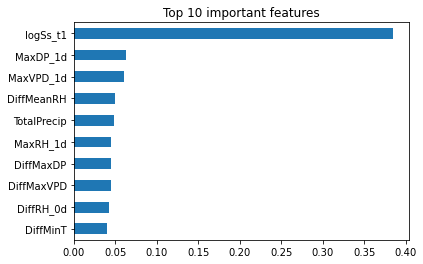

In [292]:
feat_importances = pd.Series(y100_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

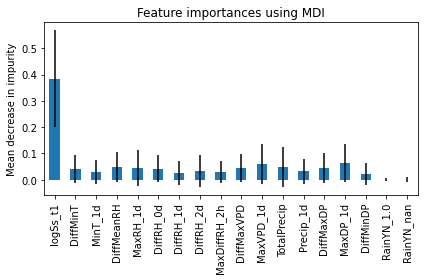

In [295]:
# plot feature importances with error bars:
# this probably only works if I save all the random forests rather than just the best 
#   estimator??? mmmm.... not sure if that makes sense; see this link for code:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = y100_rf_objects[2].steps[1][1].feature_importances_

forest_importances = pd.Series(importances, index=new_columns)
std = np.std([tree.feature_importances_ for tree in y100_rf_objects[2].steps[1][1].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Now repeat that all for the y200 cutoff (this is where the code gets pretty repetitive...

In [296]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [297]:
# threshold = 100 spores per day

y200_auc_test_scores = []
y200_rf_models = []

y200_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_log, y200_trainvalid) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_log)
    
    auc_score = roc_auc_score(y200_test, preds[:,1])
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y200_rf_models.append(model)
    
    y200_rf_objects.append(random_search_auc.best_estimator_)

    y200_auc_test_scores
    y200_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [121]:
y200_rf_results = y200_auc_test_scores.copy()
y200_rf_models = y200_rf_objects.copy()

In [298]:
# pd.DataFrame(data = y200_rf_results, index = feature_set_names, columns = ['y200'])

In [299]:
# preds = y200_rf_models[1].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
# score_metrics(y100_test_nosoil, preds[:,1], 0.5)

In [300]:
# 'RainYN' was not important in this model, so I can remove this part of the code:

# going to stick with the 'VIF' features set, since it was ALMOST the best performer
#ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)
#ohe_feature_names = list(ohe.get_feature_names(categorical_features))
#new_columns = feature_sets[2] + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns

In [301]:
# feat_importances = pd.Series(rf_objects[1].steps[1][1].feature_importances_,
#                              index=feature_sets[1])
# feat_importances.nlargest(15).plot(kind='barh')
# plt.title("Top 15 important features")
# plt.show()

#### update data sets to reflect the LASSO selection for 500 threshold:

In [123]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [124]:
# threshold = 500 spores per day

y500_auc_test_scores = []
y500_rf_models = []

y500_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_log, y500_trainvalid) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_log)
    
    auc_score = roc_auc_score(y500_test, preds[:,1])
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y500_rf_models.append(model)
    
    y500_rf_objects.append(random_search_auc.best_estimator_)

    y500_auc_test_scores
    y500_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [125]:
y500_rf_results = y500_auc_test_scores.copy()
y500_rf_models = y500_rf_objects.copy()

In [304]:
# pd.DataFrame(data = y500_rf_results, index = feature_set_names, columns = ['y500'])

Plot the most important features:

In [305]:
# feature_sets[2]

In [302]:
# cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
# cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
#                                     # could use a separate 'numeric' variable list and add that, but
#                                     # that has some complications

# ohe = rf_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
# ohe_feature_names = list(ohe.get_feature_names(categorical_features))
# new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
#                         # feature_sets[2].remove('RainYN')
# new_columns

In [303]:
# feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,
#                              index=new_columns)
# feat_importances.nlargest(15).plot(kind='barh')
# plt.title("Top 15 important features")
# plt.show()

### Now for 1,000 threshold:

In [1319]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [128]:
# threshold = 1000 spores per day

y1000_auc_test_scores = []
y1000_rf_models = []

y1000_rf_objects = []


## NB: data sets called in this loop have not been preprocessed - doing so is part of the pipeline/program
for features in feature_sets:
    # create numeric and categorical feature lists for pipeline - these are based on the selected ones from
    #     above
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    # create rf pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state = 545))
    ])
    # create param_dist dict
    param_dist = {
        'model__n_estimators'     : scipy.stats.randint(low=10, high=100),
        'model__max_depth'        : scipy.stats.randint(low=3, high=10),
        'model__class_weight'     : (None, "balanced")
    }

    # create randomized search CV
    random_search_auc = RandomizedSearchCV(rf_pipeline,
                                    param_distributions= param_dist,
                                     n_iter = 30,
                                     cv = 5,
                                     scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                                     verbose = 1,
                                     random_state = 454)
    
    # obtain AUC values from each of the models
    random_search_auc.fit(X_trainvalid_log, y1000_trainvalid) 
    auc_score = ()
    
    preds = random_search_auc.best_estimator_.predict_proba(X_test_log)
    
    auc_score = roc_auc_score(y1000_test, preds[:,1])
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = random_search_auc.best_estimator_.steps[1][1]
    y1000_rf_models.append(model)
    
    y1000_rf_objects.append(random_search_auc.best_estimator_)

    y1000_auc_test_scores
    y1000_rf_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [129]:
y1000_rf_results = y1000_auc_test_scores.copy()
y1000_rf_models = y1000_rf_objects.copy()

In [306]:
# pd.DataFrame(data = y1000_rf_results, index = feature_set_names, columns = ['y1000'])

In [307]:
# feat_importances = pd.Series(rf_objects[2].steps[1][1].feature_importances_,
#                              index=feature_sets[2])
# feat_importances.nlargest(15).plot(kind='barh')
# plt.title("Top 15 important features")
# plt.show()

### Combine all results into one data frame:

In [134]:
pd.DataFrame(data = list(zip(y100_rf_results, y200_rf_results, y500_rf_results, y1000_rf_results)),
                     index = feature_set_names, 
             columns = ['y100', 'y200', 'y500', 'y1000'])

,ylog,y100,y200,y500,y1000
features_all,-0.035255,0.582583,0.618424,0.525267,0.572596
features_lasso,0.291463,0.675791,0.773431,0.758021,0.790383
features_VIF,0.284545,0.702934,0.761052,0.772059,0.739786
features_no_correlation,0.288417,0.694733,0.757515,0.731150,0.747172
features_same_day,-0.045399,0.528991,0.575321,0.561364,0.551069
features_previous_day,-0.046910,0.506699,0.560455,0.533824,0.492772
features_differences,-0.037870,0.598868,0.584273,0.606684,0.588624


# Logistic Regression

-- nb, code needs some reorganizing here in order to run properly --

Here I'll repeat the above, except using logistic regression. For comparison purposes, I will perform a similar analysis in R using more 'statistically sound' assumptions than here.

In [135]:
features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [138]:
# Using y100 as the threshold:

y100_auc_test_scores = []
y100_lr_models = []

y100_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y100_lr_models.append(model)
    
    y100_lr_objects.append(grid_search_auc.best_estimator_)
    y100_auc_test_scores
    y100_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [140]:
y100_lr_results = y100_auc_test_scores.copy()
y100_lr_models = y100_lr_objects.copy()

In [141]:
pd.DataFrame(data = y100_lr_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.568261
features_lasso,0.706168
features_VIF,0.728575
features_no_correlation,0.723377
features_same_day,0.525410
features_previous_day,0.564911
features_differences,0.662740


In [1335]:
y100_lr_models[5][1].coef_[0]

array([ 2.10556150e-03,  2.48637133e-03, -1.13805267e-03, -4.44794924e-03,
       -2.48234484e-03, -2.74514611e-03,  3.60789620e-03,  2.47358734e-03,
        1.93575691e-03, -2.84772755e-03, -2.36306818e-03,  1.02718363e-03,
       -4.68847543e-03, -2.40485890e-03,  3.63221729e-05])

Plot the top 15 coefficients:

In [1042]:
feature_sets[2]

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'RainYN',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP']

In [1043]:
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns

['logSs_t1',
 'DiffMinT',
 'MinT_1d',
 'DiffMeanRH',
 'MaxRH_1d',
 'DiffRH_0d',
 'DiffRH_1d',
 'DiffRH_2d',
 'MaxDiffRH_2h',
 'DiffMaxVPD',
 'MaxVPD_1d',
 'TotalPrecip',
 'Precip_1d',
 'DiffMaxDP',
 'MaxDP_1d',
 'DiffMinDP',
 'RainYN_1.0',
 'RainYN_nan']

In [1056]:
lr_objects[2].steps[1][1].coef_

array([[ 4.67995241e-01,  1.98463588e-04, -3.73681283e-02,
        -2.42870940e-02, -9.27753876e-02,  1.76758145e-02,
        -2.03797853e-03,  3.90913322e-02,  5.60918800e-02,
         4.40394985e-02,  1.26568886e-01, -1.24710865e-01,
         3.60246951e-02,  6.10709152e-02,  1.00681050e-01,
        -3.14846791e-02, -6.08479236e-02, -3.85000698e-02]])

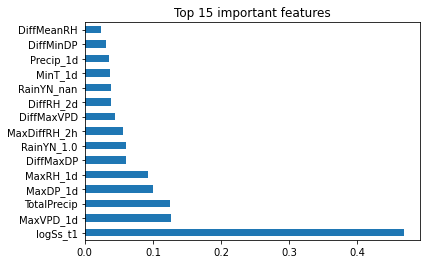

In [1058]:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

Now try for y200:

In [1344]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [142]:
# Using y200 as the threshold:

y200_auc_test_scores = []
y200_lr_models = []

y200_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y200_lr_models.append(model)
    
    y200_lr_objects.append(grid_search_auc.best_estimator_)
    y200_auc_test_scores
    y200_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [143]:
y200_lr_results = y200_auc_test_scores.copy()
y200_lr_models = y200_lr_objects.copy()

In [144]:
pd.DataFrame(data = y200_lr_results, index = feature_set_names, columns = ['y200'])

,y200
features_all,0.600298
features_lasso,0.751437
features_VIF,0.764589
features_no_correlation,0.758621
features_same_day,0.581952
features_previous_day,0.567418
features_differences,0.618866


In [1409]:
preds = y200_lr_models[2].predict_proba(X_test_nosoil_log)
#np.array(preds[:,1])
score_metrics(y200_test_nosoil, preds[:,1], 0.5)
#roc_auc_score(y200_test_nosoil, preds[:,1])

,value
accuracy,0.560209
precision,1.000000
recall,0.034483
specificity,1.000000
F1,0.066667
AUC,0.757737


In [1062]:
cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = lr_objects[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns;

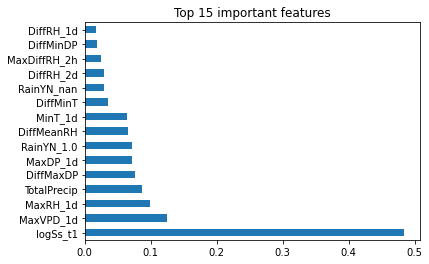

In [1063]:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1348]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [145]:
# Using y500 as the threshold:

y500_auc_test_scores = []
y500_lr_models = []

y500_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y500_lr_models.append(model)
    
    y500_lr_objects.append(grid_search_auc.best_estimator_)
    y500_auc_test_scores
    y500_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [146]:
y500_lr_results = y500_auc_test_scores.copy()
y500_lr_models = y500_lr_objects.copy()

In [147]:
pd.DataFrame(data = y500_auc_test_scores, index = feature_set_names, columns = ['y500'])

,y500
features_all,0.578877
features_lasso,0.758690
features_VIF,0.766444
features_no_correlation,0.753743
features_same_day,0.567112
features_previous_day,0.579412
features_differences,0.558289


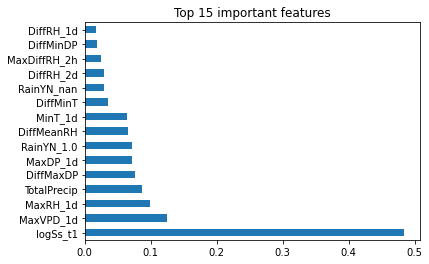

In [1074]:
# same thing as above, so I don't need to make new column names:
feat_importances = pd.Series(np.abs(lr_objects[2].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index=new_columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1352]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [151]:
# Using y1000 as the threshold:

y1000_auc_test_scores = []
y1000_lr_models = []

y1000_lr_objects = []


for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] # some function to select numeric features
    cat_features = [i for i in features if i in categorical_features] # if this is a blank list, I believe that's fine
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])
    
    #if len(cat_features) > 0:   # check if cat_features is empty, as this may cause problems in the pipeline
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    # question: what happens if there are no categorical features? - sort out in the debugging stage
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter = 1000, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.0001, 0.001, 0.01, 0.1, 1, 10),
        'model__class_weight'   : (None, 'balanced')
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(lr_pipeline,
                              param_grid=param_dist,
                              cv = 10,
                              scoring = 'roc_auc', # maximize auc score (ways to do multiplie criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y1000_lr_models.append(model)
    
    y1000_lr_objects.append(grid_search_auc.best_estimator_)
    y1000_auc_test_scores
    y1000_lr_models

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [152]:
y1000_lr_results = y1000_auc_test_scores.copy()
y1000_lr_models = y1000_lr_objects.copy()

In [153]:
pd.DataFrame(data = y1000_lr_results, index = feature_set_names, columns = ['y1000'])

,y1000
features_all,0.595380
features_lasso,0.775299
features_VIF,0.755185
features_no_correlation,0.753771
features_same_day,0.614551
features_previous_day,0.521684
features_differences,0.516656


In [1356]:
feature_sets[1]

['logSs_t1']

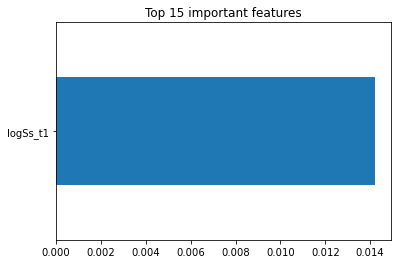

In [1081]:
# ok this time the LASSO data set with just one variable won out:
feat_importances = pd.Series(np.abs(lr_objects[1].steps[1][1].coef_[0]), # take absolute values
                             # of importances
                             index= feature_sets[1])
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [1357]:
# combine all results:
pd.DataFrame(data = list(zip(y100_lr_results, y200_lr_results, y500_lr_results, y1000_lr_results)),
                     index = feature_set_names, 
             columns = ['y100', 'y200', 'y500', 'y1000'])

,y100,y200,y500,y1000
features_all,0.573112,0.607317,0.551738,0.573067
features_lasso,0.686879,0.747569,0.555080,0.568825
features_VIF,0.723031,0.770447,0.540642,0.576367
features_biology,0.522523,0.570734,0.543984,0.579510
features_no_correlation,0.707785,0.746021,0.553342,0.578253
features_same_day,0.529106,0.584439,0.546257,0.562382
features_previous_day,0.563063,0.571729,0.558289,0.588152
features_differences,0.648764,0.597812,0.544385,0.583909


# Support Vector Machines

Repeat all of the above for SVM

In [154]:
features_lasso = list(larcv_coefs[larcv_coefs['y100'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [156]:
# as above for threshold = 100 spores per day:

y100_auc_test_scores = []
y100_svm_models = []

y100_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y100_test_nosoil, preds[:,1])
    
    y100_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y100_svm_models.append(model)
    
    y100_svm_objects.append(grid_search_auc.best_estimator_)

    y100_auc_test_scores
    y100_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [157]:
y100_svm_results = y100_auc_test_scores.copy()
y100_svm_models = y100_svm_objects.copy()

In [158]:
pd.DataFrame(data = y100_svm_results, index = feature_set_names, columns = ['y100'])

,y100
features_all,0.442134
features_lasso,0.686648
features_VIF,0.725341
features_no_correlation,0.724532
features_same_day,0.522754
features_previous_day,0.436013
features_differences,0.542389


Repeat for cuttoff of 200 ascospores per day:

In [1285]:
features_lasso = list(larcv_coefs[larcv_coefs['y200'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [159]:
# as above for threshold = 200 spores per day:

y200_auc_test_scores = []
y200_svm_models = []

y200_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y200_test_nosoil, preds[:,1])
    
    y200_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y200_svm_models.append(model)
    
    y200_svm_objects.append(grid_search_auc.best_estimator_)

    y200_auc_test_scores
    y200_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [160]:
y200_svm_results = y200_auc_test_scores.copy()
y200_svm_models = y200_svm_objects.copy()

In [161]:
pd.DataFrame(data = y200_svm_results, index = feature_set_names, columns = ['y200'])

,y200
features_all,0.401359
features_lasso,0.751216
features_VIF,0.769065
features_no_correlation,0.765805
features_same_day,0.424790
features_previous_day,0.433908
features_differences,0.575652


Repeat for features cutoff of 500 ascospores per day:

In [162]:
features_lasso = list(larcv_coefs[larcv_coefs['y500'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [163]:
# as above for threshold = 500 spores per day:

y500_auc_test_scores = []
y500_svm_models = []

y500_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y500_test_nosoil, preds[:,1])
    
    y500_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y500_svm_models.append(model)
    
    y500_svm_objects.append(grid_search_auc.best_estimator_)

    y500_auc_test_scores
    y500_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [1282]:
#preds[:,0]
#preds = y500_svm_models[0].predict_proba(X_test_nosoil_log)
#roc_auc_score(y500_test_nosoil, preds[:,0])


In [164]:
y500_svm_results = y500_auc_test_scores.copy()
y500_svm_models = y500_svm_objects.copy()

In [165]:
pd.DataFrame(data = y500_svm_results, index = feature_set_names, columns = ['y500'])

,y500
features_all,0.433957
features_lasso,0.764037
features_VIF,0.758757
features_no_correlation,0.745455
features_same_day,0.544853
features_previous_day,0.425668
features_differences,0.558021


Repeat for 1,000 ascospores per day

In [1280]:
features_lasso = list(larcv_coefs[larcv_coefs['y1000'] > 1e-6].index.values)

feature_sets = [features_all, features_lasso, features_VIF, features_no_correlation,
               features_same_day, features_previous_day, features_differences]
feature_set_names = ['features_all', 'features_lasso', 'features_VIF', 'features_no_correlation',
                     'features_same_day', 'features_previous_day', 'features_differences']

In [166]:
# as above for threshold = 1000 spores per day:

y1000_auc_test_scores = []
y1000_svm_models = []

y1000_svm_objects = []

for features, name in zip(feature_sets, feature_set_names):
    num_features = [i for i in features if i in numeric_features] 
    cat_features = [i for i in features if i in categorical_features] 
    
    # create preprocessor
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(sample_posterior = False, 
                                     max_iter = 500, random_state = 356))
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='error', drop = 'first')),
        ('imputer', SimpleImputer(strategy='most_frequent'))
     ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ])
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability = True, random_state = 545))
    ])

    # I need to create
    #   a dict of values I want to test in the random search
    param_dist = {
        'model__C'              : (0.01, 0.1, 1.0, 10, 100),
        'model__class_weight'   : (None, 'balanced'),
        'model__gamma'        : (0.01, 0.1, 1.0)
    }

    # Create the GridSearchCV
    grid_search_auc = GridSearchCV(svm_pipeline,
                              param_grid=param_dist,
                              cv = 5,
                              scoring = 'roc_auc', # maximize the auc score (ways to do multiple criteria)
                              verbose = 1)
    
    # obtain AUC values from each of the models
    grid_search_auc.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil) 
    auc_score = ()
    
    preds = grid_search_auc.best_estimator_.predict_proba(X_test_nosoil_log)
    
    auc_score = roc_auc_score(y1000_test_nosoil, preds[:,1])
    
    y1000_auc_test_scores.append(auc_score)
    
    # save models in a dict
    model = ()
    model = grid_search_auc.best_estimator_.steps[1][1]
    y1000_svm_models.append(model)
    
    y1000_svm_objects.append(grid_search_auc.best_estimator_)

    y1000_auc_test_scores
    y1000_svm_models
    


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [167]:
y1000_svm_results = y1000_auc_test_scores.copy()
y1000_svm_models = y1000_svm_objects.copy()

In [168]:
pd.DataFrame(data = y1000_svm_results, index = feature_set_names, columns = ['y1000'])

,y1000
features_all,0.535512
features_lasso,0.778284
features_VIF,0.749529
features_no_correlation,0.764535
features_same_day,0.402891
features_previous_day,0.465745
features_differences,0.560497


In [169]:
# combine all data for final results table:
# combine all results:
pd.DataFrame(data = list(zip(y100_svm_results, y200_svm_results, y500_svm_results, y1000_svm_results)),
                     index = feature_set_names, 
             columns = ['y100', 'y200', 'y500', 'y1000'])

,y100,y200,y500,y1000
features_all,0.442134,0.401359,0.433957,0.535512
features_lasso,0.686648,0.751216,0.764037,0.778284
features_VIF,0.725341,0.769065,0.758757,0.749529
features_no_correlation,0.724532,0.765805,0.745455,0.764535
features_same_day,0.522754,0.424790,0.544853,0.402891
features_previous_day,0.436013,0.433908,0.425668,0.465745
features_differences,0.542389,0.575652,0.558021,0.560497


In [1206]:
# predictions are different between runs... would I have to 
y1000_svm_models[2].predict(X_test_nosoil_log).sum()

55

In [1220]:
grid_search_auc.best_estimator_.score(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil)
# pd.DataFrame(grid_search_auc.cv_results_)
grid_search_auc.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [1213]:
#y100_svm_objects
y1000_svm_models[7][1]

SVC(C=10, gamma=0.1, probability=True, random_state=545)

In [1242]:
y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)
auc_val = roc_auc_score(y1000_svm_pred, y1000_test_nosoil)
auc_val

0.6236144578313253

In [1240]:
# I think only LR has probabilities; therefore maybe use the non-probability metrics:
y1000_svm_pred = y1000_svm_models[7].predict(X_test_nosoil_log)

#y1000_sm_pred = y1000_svm_models[2].

score_metrics_no_prob(y1000_test_nosoil, y1000_svm_pred)

,value
accuracy,0.759162
precision,0.440000
recall,0.255814
specificity,0.905405
F1,0.323529
AUC,0.580610


## Classification model evaluation statistics AND feature importances for all models:

Here I'll summarize the models based on the statistics I've decided on above (in the 'score_metrics()' function I've defined). These are primarily for the classification models.

I'm going to focus on VIF-models 

First, create null models for all of these:

In [210]:
# evaluate null models:
dummy_reg = DummyRegressor()
dummy_reg.fit(X_trainvalid_nosoil_log, y_trainvalid_nosoil_log)

dc_100 = DummyClassifier(strategy='prior')
dc_100.fit(X_trainvalid_nosoil_log, y100_trainvalid_nosoil)

dc_200 = DummyClassifier(strategy='prior')
dc_200.fit(X_trainvalid_nosoil_log, y200_trainvalid_nosoil)

dc_500 = DummyClassifier(strategy='prior')
dc_500.fit(X_trainvalid_nosoil_log, y500_trainvalid_nosoil)

dc_1000 = DummyClassifier(strategy='prior')
dc_1000.fit(X_trainvalid_nosoil_log, y1000_trainvalid_nosoil);

#rf500_probs = y500_rf_models[2].predict_proba(X_test_nosoil_log)

#score_metrics(y500_test_nosoil, rf500_probs[:,1], 0.5)

In [204]:
# for regression:
preds = dummy_reg.predict(X_test_nosoil_log)
print(r2_score(y_test_nosoil_log, preds))
print(100*np.mean(np.abs((preds - y_test_nosoil_log)/y_test_nosoil_log)))
print(mean_squared_error(y_test_nosoil_log, preds))

-0.06287204887821218
inf
0.6916652091441942


In [212]:
# for classification:
dummy_model_sets = [dc_100, dc_200, dc_500, dc_1000]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

dummy_scores_df = pd.DataFrame()

for models, test in zip(dummy_model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    dummy_scores_df = pd.concat([dummy_scores_df, scores], axis=1)
    
dummy_scores_df.columns = ['y100', 'y200', 'y500', 'y1000']
dummy_scores_df

<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
<ipython-input-2-d6cf8bb53d5f>:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,y100,y200,y500,y1000
accuracy,0.612565,0.455497,0.712042,0.774869
precision,0.612565,0.455497,NaN,NaN
recall,1.000000,1.000000,0.000000,0.000000
specificity,0.000000,0.000000,1.000000,1.000000
F1,0.759740,0.625899,NaN,NaN
AUC,0.500000,0.500000,0.500000,0.500000


In [190]:
# models = [y500_rf_models[2], y500_lr_models[2], y500_svm_models[2]]

# scores_df = pd.DataFrame()

# for m in models:
#     probs = m.predict_proba(X_test_nosoil_log)
    
#     scores = score_metrics(y500_test_nosoil, probs[:,1], 0.5)
    
#     scores_df = pd.concat([scores_df, scores], axis=1)
    
# scores_df.columns = ['randomforest', 'logistic', 'SVM']
# scores_df

,randomforest,logistic,SVM
accuracy,0.753927,0.748691,0.753927
precision,0.600000,0.600000,0.590909
recall,0.436364,0.381818,0.472727
specificity,0.882353,0.897059,0.867647
F1,0.505263,0.466667,0.525253
AUC,0.772059,0.766444,0.758757


In [189]:
# random forest models:

model_sets = [y100_rf_models[2], y200_rf_models[2], y500_rf_models[2], y1000_rf_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_df = pd.concat([scores_df, scores], axis=1)
    
scores_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_df

,y100,y200,y500,y1000
accuracy,0.649215,0.675393,0.753927,0.795812
precision,0.771739,0.647059,0.600000,0.547619
recall,0.606838,0.632184,0.436364,0.534884
specificity,0.716216,0.711538,0.882353,0.871622
F1,0.679426,0.639535,0.505263,0.541176
AUC,0.702934,0.761052,0.772059,0.739786


In [213]:
# logistic regression models:

model_sets = [y100_lr_models[2], y200_lr_models[2], y500_lr_models[2], y1000_lr_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_lr_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_lr_df = pd.concat([scores_lr_df, scores], axis=1)
    
scores_lr_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_lr_df

,y100,y200,y500,y1000
accuracy,0.664921,0.722513,0.748691,0.795812
precision,0.797753,0.717949,0.600000,1.000000
recall,0.606838,0.643678,0.381818,0.093023
specificity,0.756757,0.788462,0.897059,1.000000
F1,0.689320,0.678788,0.466667,0.170213
AUC,0.728575,0.764589,0.766444,0.755185


In [214]:
# SVM models:

model_sets = [y100_svm_models[2], y200_svm_models[2], y500_svm_models[2], y1000_svm_models[2]]
test_sets = [y100_test_nosoil, y200_test_nosoil, y500_test_nosoil, y1000_test_nosoil]

scores_svm_df = pd.DataFrame()

for models, test in zip(model_sets, test_sets):
    probs = models.predict_proba(X_test_nosoil_log)
    
    scores = score_metrics(test, probs[:,1], 0.5)
    
    scores_svm_df = pd.concat([scores_svm_df, scores], axis=1)
    
scores_svm_df.columns = ['y100', 'y200', 'y500', 'y1000']
scores_svm_df

,y100,y200,y500,y1000
accuracy,0.607330,0.643979,0.753927,0.801047
precision,0.617978,0.579832,0.590909,0.666667
recall,0.940171,0.793103,0.472727,0.232558
specificity,0.081081,0.519231,0.867647,0.966216
F1,0.745763,0.669903,0.525253,0.344828
AUC,0.725341,0.769065,0.758757,0.749529


#### Make feature importance plots for each of the methods; will focus on y500 threshold for now!

The tricky part is getting the right column names for each of the models. NB: never mind! The same feature set can be used for all models using the VIF variables

In [224]:

cols = list(feature_sets[2])     # CAREFUL WHEN DUPLICATING OBJECTS! CHANGES TO THE COPY CAN AFFECT THE ORIGINAL
cols.remove('RainYN') # remove this variable from the list of variables; alternatively,
                                    # could use a separate 'numeric' variable list and add that, but
                                    # that has some complications

ohe = ylog_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
new_columns = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
new_columns;

#ohe = y500_rf_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_rfclass = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_rfclass

#ohe = y500_lr_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_lr = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_lr

#ohe = y500_svm_models[2].named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
#ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
#new_columns_svm = cols + ohe_feature_names # may or may not need to remove RainYN from data set:
                        # feature_sets[2].remove('RainYN')
#new_columns_svm;

In [225]:
#print(new_columns_rfreg)
#print(new_columns_rfclass)
#print(new_columns_lr)
#print(new_columns_svm)

In [275]:
from pylab import rcParams

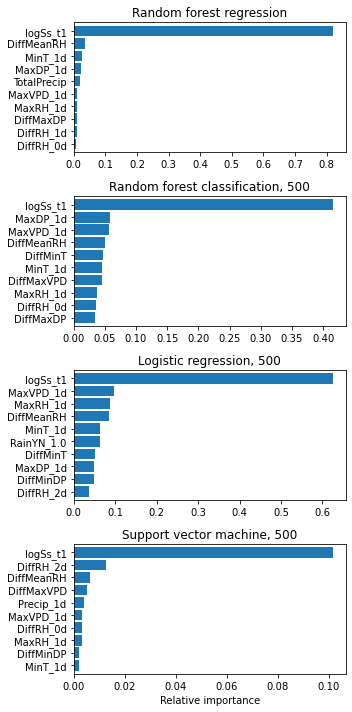

In [283]:

rcParams['figure.figsize'] = 5, 10

fig = plt.figure()

plt.subplot(4,1,1)
feat_importances_rfreg = pd.Series(ylog_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances_rfreg.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Random forest regression")
#plt.show()


plt.subplot(4,1,2)
feat_importances_rf500 = pd.Series(y500_rf_models[2].steps[1][1].feature_importances_,
                             index=new_columns)
feat_importances_rf500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Random forest classification, 500")
#plt.show()


plt.subplot(4,1,3)
feat_importances_lr500 = pd.Series(np.abs(y500_lr_models[2].steps[1][1].coef_[0]), # take absolute values here
                             index=new_columns)
feat_importances_lr500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Logistic regression, 500")
#plt.show()


# getting feature importances is a bit weird for SVM if using the 'rbf' kernel, but here it is:

plt.subplot(4,1,4)
perm_importance = permutation_importance(y500_svm_models[2], X_test_nosoil_log, y500_test_nosoil)

feature_names = X_test_nosoil_log.columns # must use all original column names
features = np.array(feature_names)

feat_importances_svm500 = pd.Series(np.abs(perm_importance.importances_mean),
                             index=features)

feat_importances_svm500.nlargest(10).sort_values(ascending = True).plot(kind='barh', width = 0.85)
plt.title("Support vector machine, 500")
plt.xlabel("Relative importance")
#plt.show()

fig.tight_layout()
#fig.subplots_adjust(hspace=0.6)
plt.savefig("feature importances.png", dpi = 300)


And also make a dataframe showing all the feature importance values:

In [286]:
blah = pd.concat([feat_importances_rfreg, feat_importances_rf500, feat_importances_lr500, feat_importances_svm500], 
                 axis=1)

blah.columns = ['rf_reg', 'rf_y500', 'lr_y500', 'svm_y500']

blah.to_csv("feature importances dataframe.csv")


In [67]:
# LASSO feature selection - need scaled features
# ONE OPTION FOR DOING THIS BELOW: this is using the transformed/encoded X data set and using the binary y
#                                  target
# Lasso:
larcv = LassoCV(n_alphas=100, cv = 10, max_iter = 10000) 

y_data_sets = [y_trainvalid_nosoil_log, y100_trainvalid_nosoil, y200_trainvalid_nosoil, 
               y500_trainvalid_nosoil, y1000_trainvalid_nosoil]
#y_data_sets = [ylog_all, y100_all, y200_all, y500_all, y1000_all]
#larcv_coefs = pd.DataFrame(index = X_all.columns)
larcv_coefs = pd.DataFrame(index = X_trainvalid.columns)

# a for loop to perform all fits at once:
for y in y_data_sets:
    larcv.fit(X_trainvalid, y)
    larcv_ycoefs = pd.DataFrame(data=abs(larcv.coef_), index=X_trainvalid.columns)
    
    larcv_coefs = pd.concat([larcv_coefs, larcv_ycoefs], axis=1)
    
larcv_coefs.columns = ['ylog', 'y100', 'y200', 'y500', 'y1000']

In [68]:
# display results; remove variables that weren't selected in any of the models (i.e. their coefficient = 0)
larcv_coefs[(larcv_coefs.T > 1e-6).any()].sort_values(by='ylog', ascending=False)

,ylog,y100,y200,y500,y1000
logSs_t1,0.368919,0.128645,0.155954,0.181878,0.14188
MeanRH,0.073478,0.000000,0.035407,0.019537,0.00000
TotalPrecip,0.063709,0.025243,0.019007,0.000000,0.00000
MaxDP,0.058479,0.030315,0.032696,0.000000,0.00000
MinTemp,0.022790,0.000000,0.040527,0.000000,0.00000
MeanVPD_1d,0.005460,0.017325,0.031176,0.001569,0.00000
MinDP_1d,0.002042,0.003667,0.000000,0.000000,0.00000
DiffRH_0d,0.000000,0.000000,0.004352,0.000000,0.00000
MeanTemp,0.000000,0.000000,0.020870,0.001591,0.00000
MaxDiffRH_3h,0.000000,0.000830,0.000000,0.000000,0.00000
